In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Bias, Variance, and Overfitting
*&copy; The Data Incubator*

In this notebook, we generate want to illustrate the notion of overfitting.  We'll generate data and use a decision tree to illustrate an example of the bias-variance tradeoff.  Let's start by generaing and plotting some data...

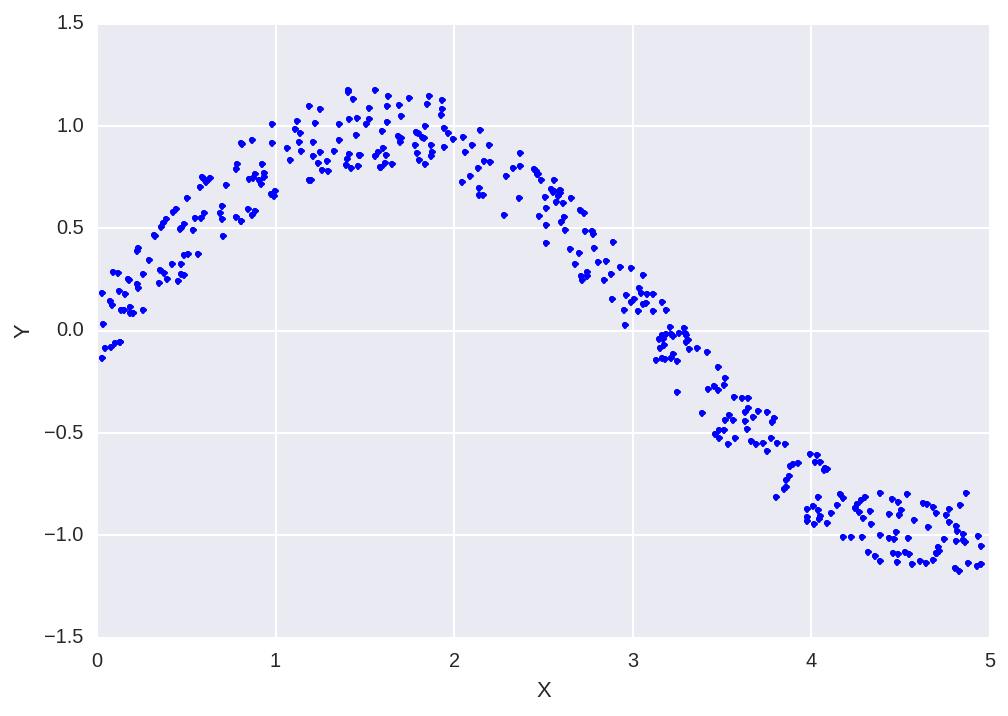

In [3]:
from IPython import display
from sklearn.externals.six import StringIO
import pydot
import numpy as np
from matplotlib import pylab as plt
 
# Create a random dataset
rng = np.random.RandomState(42) # fix the seed so the result are stable
N_points = 400
X = np.sort(5 * rng.rand(N_points, 1), axis=0)
y = np.sin(X).ravel() + .4 * (0.5 - rng.rand(N_points))

plt.plot(X, y, 'b.')
plt.xlabel('Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Decision Trees

A Decision Tree is a recursive binary tree structure.  You can read more about decision trees [here](http://scikit-learn.org/stable/modules/tree.html).  

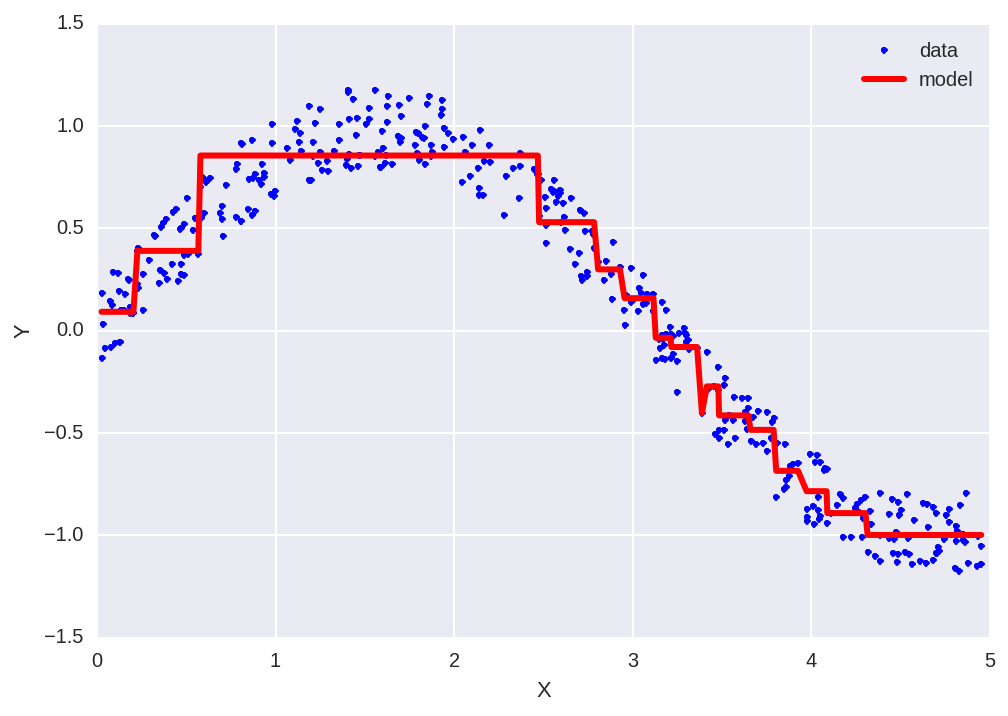

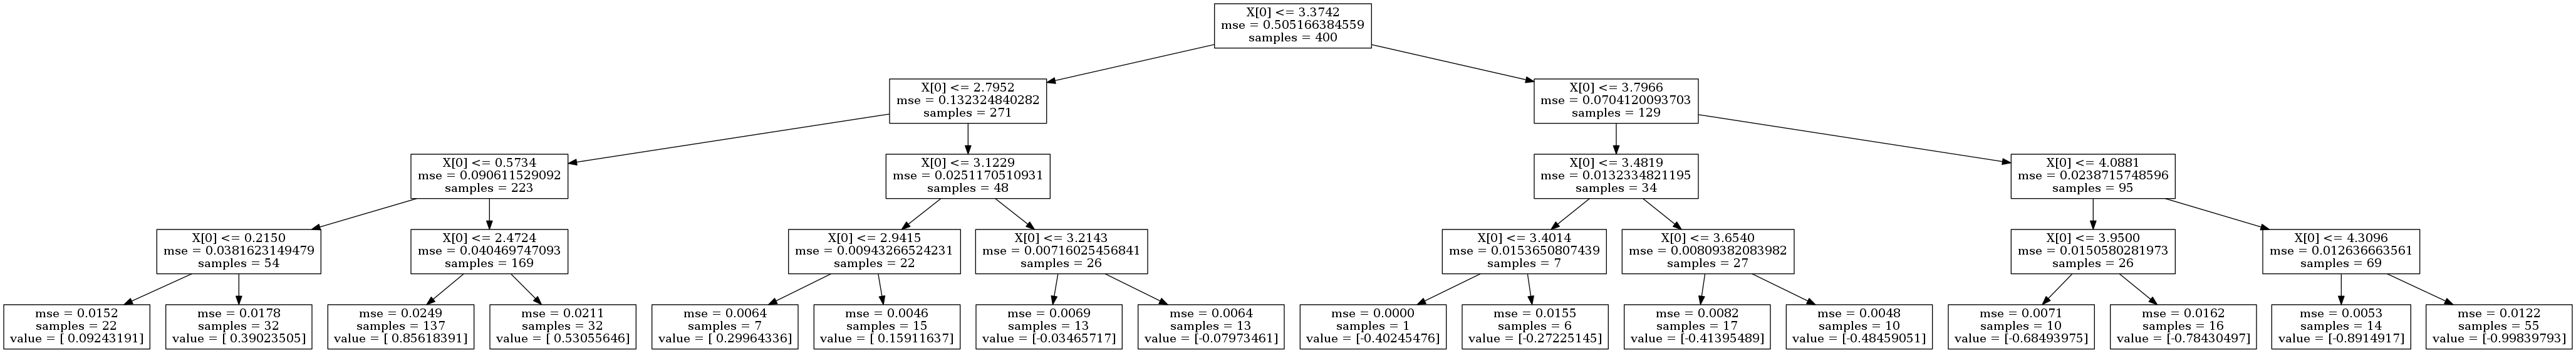

In [4]:
# Train a 2 level decision tree

from sklearn import tree
max_depth = 4
est = tree.DecisionTreeRegressor(max_depth=max_depth)
est.fit(X, y)

plt.plot(X, y, 'b.', label='data')
line = plt.plot(X, est.predict(X), 'r-', label='model')
plt.setp(line, linewidth=3.)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

dot_data = StringIO() 
tree.export_graphviz(est, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
display.Image(graph.create_png())

**Exercise:** Try playing around with `max_depth` in the above above cell.  What happens when you set it to `max_depth = 2`.  Does the fitted model look better or worse?  What about `4` or `8`?  We can tell (visually) that `max_depth = 2` is *underfitting* and `max_depth = 8` is *overfitting*.  But how can we do this computationally?

## In-sample error

Naively, you might think that we could just measure the error of the model and choose the model with the best error.  For example, let's define the error as the mean squared error (MSE).  Let's try that below

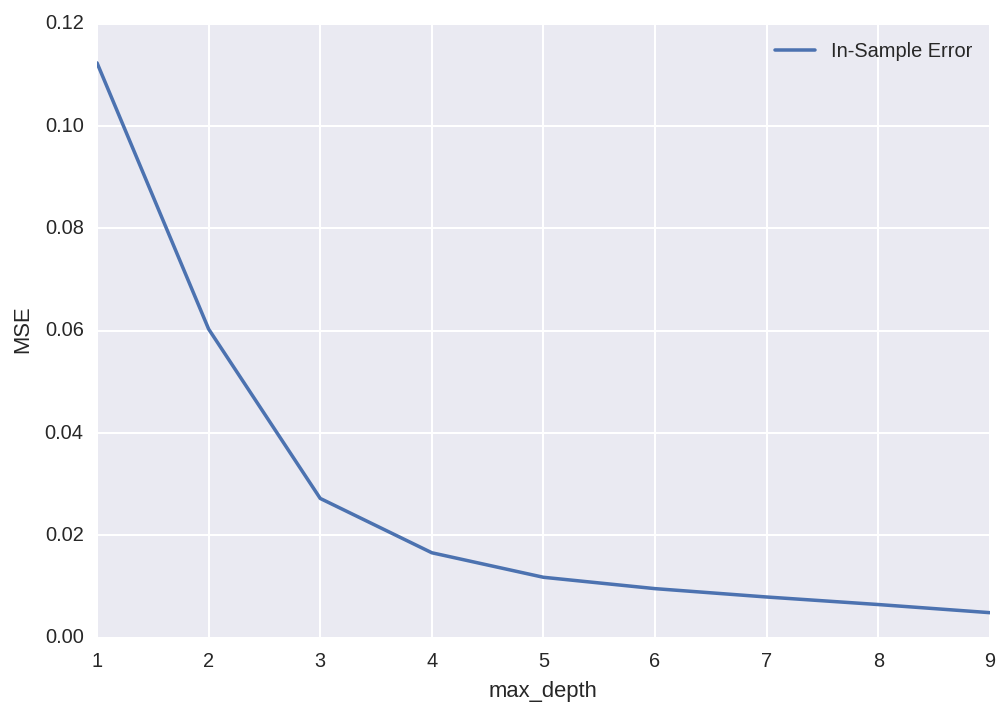

In [5]:
from sklearn import metrics

max_depths = range(1, 10)
in_sample_errors = []
for max_depth in max_depths:
    y_pred = tree.DecisionTreeRegressor(max_depth=max_depth).fit(X, y).predict(X)
    in_sample_errors.append(metrics.mean_squared_error(y, y_pred))
    
plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

We can see that the error is decreasing with the depth of the tree.  Our visual inspection told us models with `max_depth = 8` completely over-fit the error.  It turns out that the *In-Sample Error* that we calcualted above will always decrease with the complexity of the model (in this case, the depth of the tree).  We can see from above that this leads us to *overfit* the data.  In order to test how well our model *generalizes*, we need to see how it performs out new data.

## Out-of-sample error

One way to do this is to (randomly) split the data into training and test sets.  We train on the training set and test the resulting model on the test set.  Since the trained model never saw the test data, we can evaluate the performance on the test data.

In [6]:
from sklearn import cross_validation
from sklearn import metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, X_train.shape, X_test.shape

((400, 1), (320, 1), (80, 1))

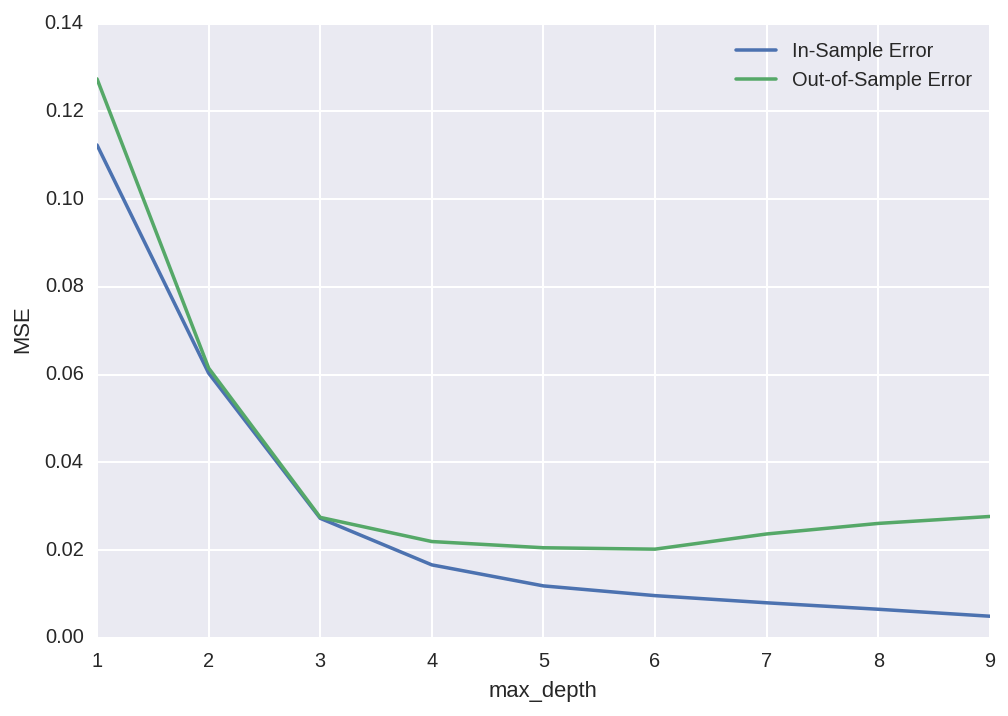

In [7]:
test_errors = []
for max_depth in max_depths:
    est = tree.DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
    y_pred = est.predict(X_test)
    test_errors.append(metrics.mean_squared_error(y_test, y_pred))

plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.plot(max_depths, test_errors, label='Out-of-Sample Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

## Variance-bias tradeoff

This is the picture we were looking for!  The *In-Sample Error* is always decreasing but the out *Out-of-Sample Error* initially decreases with model complexity (higher `max_depth`) but ultimately increases again.  The *Out-of-Sample Error* is the metric to look at when evaluating overfitting.

It turns out that this is an illustration of a very general problem in machine-learning called **Bias-Variance tradeoff** (the concept is so general that it even has a [Wikipedia article](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_dilemma).  (A more rigorous account can be found [here](http://www.brnt.eu/phd/node14.html)).  The tradeoff tells us that we can decompose our *Out-of-Sample Error* into

$$ \mbox{Out-of-Sample Error} = \mbox{Bias} + \mbox{Variance}. $$

The *Bias* corresponds to how far off we expect the model to deviate from reality (i.e. the model's bias) because of parametric assumptions (e.g. we forced the model to be linear or to be a tree of maximum depth 2).  It is given by the *In-Sample Error* of the above plot and always goes down with complexity.  High Bias models correspond to *underfitting*.

The *Variance* accounts for the fact that the model was only trained on a (noisy) subset of the data and that the idiosyncratic noise in the data is therefore likely to contribute some variance to the model.  The more complex we allow the model to be, the more likely we are to overfit by picking up more of this noise.  High variance modesl correspond to *overfitting*.

We can also think of bias as unmodelled data and variance as modelled noise.  As we increase the complexity of the model, we will necessarily model more of the data (reduce bais, reduce underfitting) but also start modelling noise (increase variance, increase overfitting).  Here's a helpful diagram of the decomposition.  Notice that at the optimal point, we have not yet learned on all our signal (still unmodelled data left) and we have picked up some noise and overfitting.

![Bias-Variance from Dartmouth](images/bias-variance.png) 

## Cross-validation strategies

The strategy we used above was a fairly elementary.  We could, for example, split the data into $k$ parts (called *folds*), train on $k-1$ of them and test the resulting model on the last one.  This is called *K-Fold Validation*.  There are many variations.  Here are a few:

- *Stratified K-Fold Validation*: restrict the folds to have the same percentage of y's as the full sample.
- *Leave-One-Out*: If $k=n$ K-Fold Validaiton.
- *Leave-$p$-Out*: You can probably guess ...

For documentation on how to use these in Scikit-Learn, take a look at [this page](http://scikit-learn.org/stable/modules/cross_validation.html).

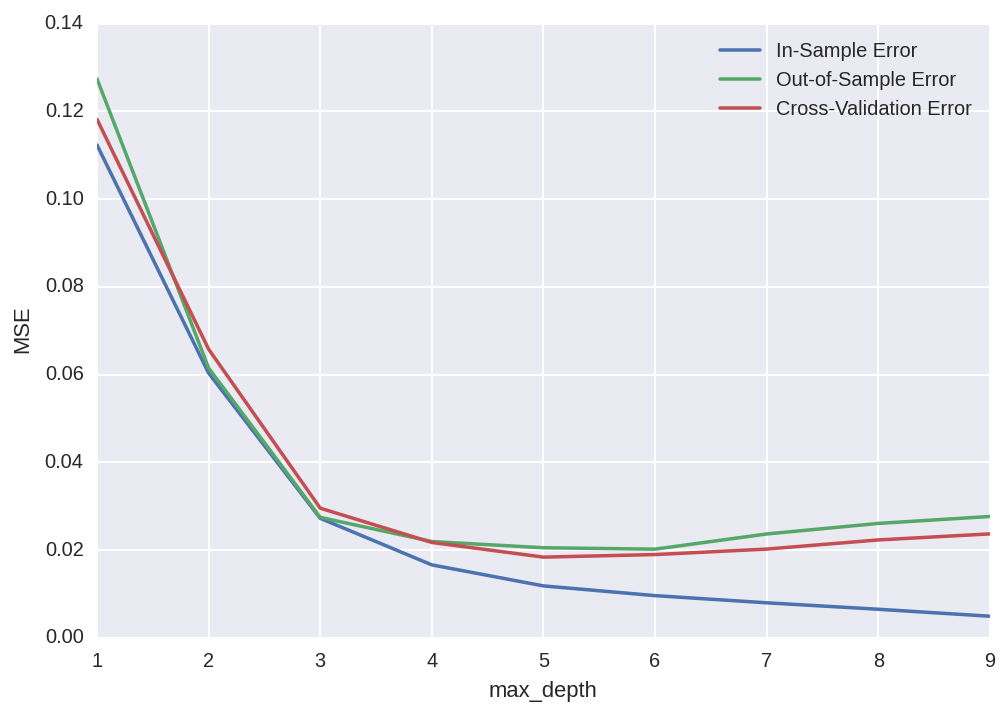

In [13]:
cv_test_errors = []

# The K-fold Cross Validation algorithm has a bug (feature?) where it makes the
# folds consecutive elements.  Because the input data is presorted along X, we have
# to first shuffle the input data.  (Exercise: What happens if we don't?)
indices = np.random.permutation(xrange(len(y)))
X_random_order, y_random_order = X[indices], y[indices]

for max_depth in max_depths:
    est = tree.DecisionTreeRegressor(max_depth=max_depth)
    
    # Note that cross_val_score performs K-fold Cross Validation but returns a score,
    # which is the negative of the error.
    cv_test_error = -cross_validation.cross_val_score(
        est,
        X_random_order,
        y_random_order,
        cv=10,  # Number of folds
        scoring='mean_squared_error'
    )
    cv_test_errors.append(cv_test_error.mean())

plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.plot(max_depths, test_errors, label='Out-of-Sample Error')
plt.plot(max_depths, cv_test_errors, label='Cross-Validation Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

## Grid search for tuning hyperparameters

Notice that we can do grid search on the hyperparameters and get back another estimator object (one that has a `.fit` and `.predict` method).  After fitting, we have a `.best_estimator_`, `.best_params_` and `.best_score_` attributes set.  You can then use `.best_params_` re instantiate an instance of your original estimator.

{'max_depth': 5}


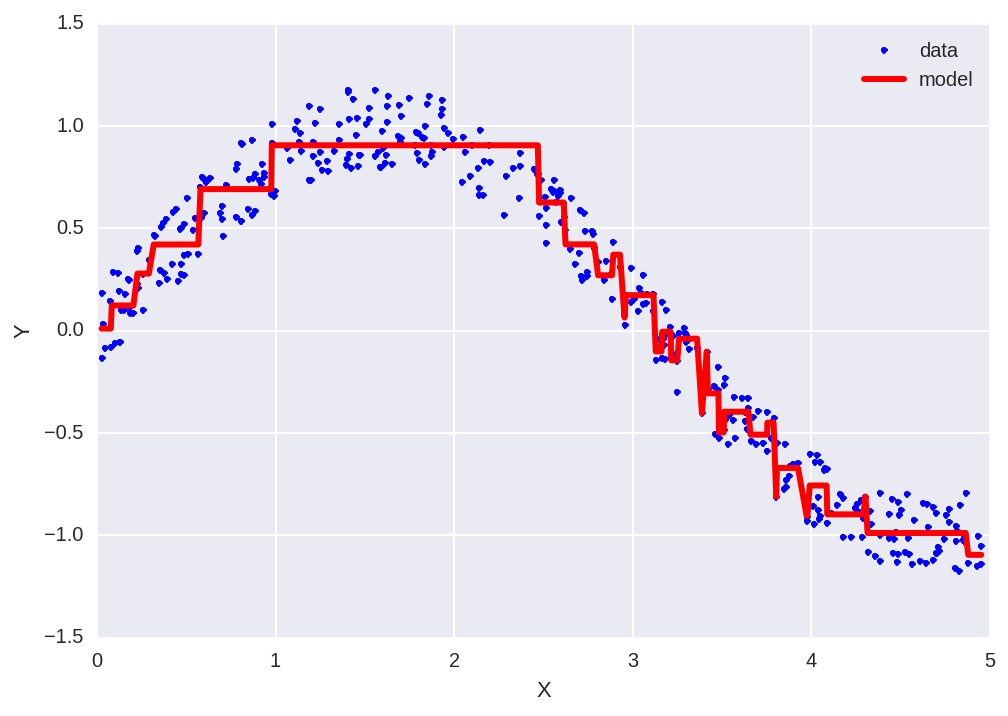

In [12]:
from sklearn import grid_search

est = tree.DecisionTreeRegressor()
gs = grid_search.GridSearchCV(
    est,
    {"max_depth": range(1,11)}, ## {"cv": range(2,11)},
    cv = 23,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='mean_squared_error'
)
gs.fit(X_random_order, y_random_order)
print gs.best_params_

plt.plot(X, y, 'b.', label='data')
line = plt.plot(X, gs.predict(X), 'r-', label='model')
plt.setp(line, linewidth=3.)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

### Questions

1. Cross validation works well in many situations.  Can you think of any situations where it is not straightforward to apply?  Is there a natural grouping where you would expect intragroup variation to be smaller than intergroup variation?

### Exercises 

1. According to the above picture, choosing the minimum *Out-of-Sample Error* or (total error) gives a model with `max_depth` of approximately 5.  Plot the model and see if the model seems reasonable.
1. There are other ways to constrain the growth of trees besides `max_depth`.  For example `min_samples_split` constrains the minimum samples below which the tree will not split and `min_samples_leaf` constrains the minimum number of samples in a leaf (terminal node of a tree).  Read about them [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).  Does increasing these increase or decrease model complexity?  Use cross validation to compute the optimal set of `min_samples_split`, `min_samples_leaf`, and `max_depth`.  *Hint*: you should use the [`grid_search` function](http://scikit-learn.org/stable/modules/grid_search.html) or [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) to find the optimal combination.
1. Finally, we used `cross_validation.cross_val_score` to compute a cross validation score inside a `for` loop.  The MSE for `cross_val_score` and `grid_search` should align exactly.  Why do these numbers align but the ones from `train_test_split` and `cross_val_score` do not?

### Exit Tickets
1. Explain the variance-bias tradeoff to your grandmother.
1. What are the benefits/drawbacks to using cross-validation versus leaving out an untouched cross-validation set?
1. In the four scenarios where in-sample error is high/low and out-of-sample error is high/low, describe what is happening in words.

### Spoilers

### Answers
Here are two examples when cross-validation might fail:
- For example, in a modelling problem, men and women may behave very differently.  Cross validation would only tell you that you have an OK model for each.
- With the stock market, a model that did well in 2000 at the height of the tech bubble , might not have done well in 2001 as the market was collapsing.

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*